In [1]:
import os

import rasterio as rs
from rasterio import features
from rasterio.features import rasterize
from PIL import Image
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## TIF로 저장하기

In [ ]:
seoul_raster = rs.open('/yh.sakong/data/satellite_image/k_satellite/seoul/C1_20220415020230_05913_00731350_L2G_RGB_PS.tif')
heatmap_raster = rs.open('/yh.sakong/data/satellite_image/k_satellite/seoul/heatmap_summer/heatmap_summer_clip.tif')

heatmap = heatmap_raster.read()

In [36]:
save_path = '//yh.sakong/data/satellite_image/k_satellite/seoul/heatmap_winter/heatmap_winter_clip_render_0_0.tif'
with rs.Env():
    profile = heatmap_raster.profile
    
    profile.update(
        count=3,
        compress='lzw',
        crs=None,
        transform=seoul_raster.profile['transform']
    )
    
    with rs.open(save_path, 'w', **profile) as dst:
        dst.write(heatmap[:3,:,:].astype(rs.uint8))

## TIF를 TIF로 Tile화 (좌표계 포함해서 tiles 만들기)

In [ ]:
import rasterio as rs
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import random
from rasterio.windows import Window


data_path = ''
w_step, h_step = 256, 256 # 각 이미지별 x,y size
save_dir = f''

os.makedirs(save_dir, exist_ok=True)

data = rs.open(data_path)
ori_width, ori_height = data.shape[::-1]

width_nums, height_nums = int(ori_width/w_step), int(ori_height/h_step)

width_off, height_off = 0, 0
for width_n in range(width_nums):
    for height_n in range(height_nums):
        width_off = w_step * width_n
        height_off = h_step * height_n
        
        # Window로 만들고 Crop하는 방식
        window = Window(width_off, height_off, w_step, h_step)
        transform = data.window_transform(window)
        
        profile = data.profile
        profile.update({
            'width': w_step,
            'height': h_step,
            'transform': transform
        })
        
        filename = f'example1_{height_n}_{width_n}.tif'
        new_path = os.path.join(save_dir, filename)
        
        with rs.open(new_path, 'w', **profile) as f:
            f.write(data.read(window=window))        

In [ ]:
import rasterio as rs
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import random
from rasterio.windows import Window


data_path = ''
w_step, h_step = 512, 512 # 각 이미지별 x,y size
save_dir = f''

os.makedirs(save_dir, exist_ok=True)

data = rs.open(data_path)
ori_width, ori_height = data.shape[::-1]

width_nums, height_nums = int(ori_width/w_step), int(ori_height/h_step)

width_off, height_off = 0, 0
for width_n in range(width_nums):
    for height_n in range(height_nums):
        width_off = w_step * width_n
        height_off = h_step * height_n
        
        # Window로 만들고 Crop하는 방식
        window = Window(width_off, height_off, w_step, h_step)
        transform = data.window_transform(window)
        
        profile = data.profile
        profile.update({
            'width': w_step,
            'height': h_step,
            'transform': transform
        })
        
        filename = f'example1_{height_n}_{width_n}.tif'
        new_path = os.path.join(save_dir, filename)
        
        with rs.open(new_path, 'w', **profile) as f:
            f.write(data.read(window=window))   

## TIF to PNG

In [10]:
def image_to_arr(path, clahe=True, grid=(8,8)):
    """이미지 파일( `.png`, `.jpg`, `.tif` 등)을 `np.array` 로 불러오는 함수 
    
    이미지 파일의 dtype이 `uint8` 이 아닌 경우 정규화를 적용함.

    Args: 
        path (str): 이미지 파일 경로
        clahe (bool, optional) : CLAHE 적용 여부. Default: `True`
        grid (tuple, optional) : CLAHE 적용 시 사용할 grid size. Default: (8,8)
        
    Returns:
        array: Array of Input Image with Normalization
        
    Examples::
    
        >>> path = 'example.tif' # (1024, 1024, 3)
        >>> img_arr = image_to_arr(path)
        >>> img_arr.shape
        >>> # (1024, 1024, 3)

    """
    if pathlib.Path(path).suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
        data = np.array(Image.open(path))
        H, W = data.shape[:2]

        assert data.ndim == 3, f'Image should be 3 dimensions, current {img_rgb.ndim}'
        assert data.shape[2] == 3, f'Image should be RGB or RGBA data, current {img_rgb.shape}'
        if np.isnan(data).any():
            data = np.nan_to_num(data)
            
        _red = data[:,:,0]
        _green = data[:,:,1]
        _blue = data[:,:,2]
                
    else:
        data = rs.open(path)
        dtypes = data.dtypes
        H, W = data.shape
        
        assert len(set(dtypes)) == 1, f'check each band types{[dt for dt in dtypes]}'
#         assert data.count == 3, f'.tif(.tiff) file only support 3 Bands(Channels), Current {data.count}' 
        # bands == 3만 지원합니다.
        
        _arr   = data.read()
        if np.isnan(_arr).any():
            _arr = np.nan_to_num(_arr)

        _red   = np.array(_arr[0,:,:], dtype=np.float32)
        _green = np.array(_arr[1,:,:], dtype=np.float32)
        _blue  = np.array(_arr[2,:,:], dtype=np.float32)
        if dtypes[0] != 'uint8':
            _red   = 255 * ((_red - np.min(_red)) / (np.max(_red) - np.min(_red)))
            _green = 255 * ((_green - np.min(_green)) / (np.max(_green) - np.min(_green)))
            _blue  = 255 * ((_blue - np.min(_blue)) / (np.max(_blue) - np.min(_blue)))
        
    if clahe:
        fn = cv2.createCLAHE(clipLimit=2, tileGridSize=grid)
        _red   = fn.apply(np.asarray(_red, dtype=np.uint8))
        _green = fn.apply(np.asarray(_green, dtype=np.uint8))
        _blue  = fn.apply(np.asarray(_blue, dtype=np.uint8))
        
    img_rgb = np.zeros((H,W,3))
    img_rgb[:,:,0] = _red
    img_rgb[:,:,1] = _green
    img_rgb[:,:,2] = _blue
    
    return img_rgb.astype(np.uint8)

In [ ]:
tif = rs.open('/yh.sakong/data/satellite_image/k_satellite/seoul/seoul_rgb.tif')
arr = tif.read()

## Shape to Label

In [1]:
import os

import rasterio as rs
from rasterio import features
from rasterio.features import rasterize

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

vector = gpd.read_file('/home/yh.sakong/data/satellite_image/shape_to_label/daesang.shp')
raster = rs.open('/home/yh.sakong/data/satellite_image/shape_to_label/image/T52SCF_20221019T021709_TCI_10m.jp2')

vector = vector.to_crs('EPSG:32652')
vector = vector.dissolve(by='수종', aggfunc='sum')
vector['id'] = range(0,len(vector))

geom_value = [(geom,value) for geom, value in zip(vector.geometry, vector['id'])]
rasterized = rasterize(geom_value,
                        out_shape = raster.shape,
                        transform = raster.transform,
                        dtype=np.int16,
                        all_touched = True,
                        fill = 0,   # background value
)


plt.figure(figsize=(15,15))
plt.imshow(rasterized[3800:4400, 2500:3200])

DriverError: /home/yh.sakong/data/satellite_image/shape_to_label/daesang.shp: No such file or directory

## TIF float을 Int로 바꾸고 다시 저장

## 좌표계 부여하기
- QGIS로 GCP 점 가져와서 적용하기

##

## Remove

In [ ]:
ndvi = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/합천용주면_산불_20230308/fire_ndvi_list/NDVI.tif').read()
gndvi = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/합천용주면_산불_20230308/fire_ndvi_list/GNDVI.tif').read()
savi = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/합천용주면_산불_20230308/fire_ndvi_list/SAVI.tif').read()
msavi2 = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/합천용주면_산불_20230308/fire_ndvi_list/MSAVI2.tif').read()

In [97]:
Image.MAX_IMAGE_PIXELS = None

In [194]:
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import tqdm
import cv2
import rasterio as rs

from patchify import patchify
from PIL import Image
from Geolib import raster

import math

from tqdm import tqdm

from Geolib import raster

import multiprocessing

pre = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/NDVI_pre_cut.tif')
pre_vis = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/합천용주면_산불_20230308/CompResult_CAS_20211103_CIR_s.tif').read()
post = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/NDVI_post_cut.tif')
post_vis = rs.open('/yh.sakong/data/satellite_image/k_satellite/fire/합천용주면_산불_20230308/merge_post.tif').read()

In [195]:
pre_flip = cv2.flip(pre_vis.transpose(1,2,0), 0)

In [197]:
Image.fromarray(pre_flip).save('./pre_result.png')
Image.fromarray(post_vis[3:6].transpose(1,2,0).astype(np.uint8)).save('./post_result.png')

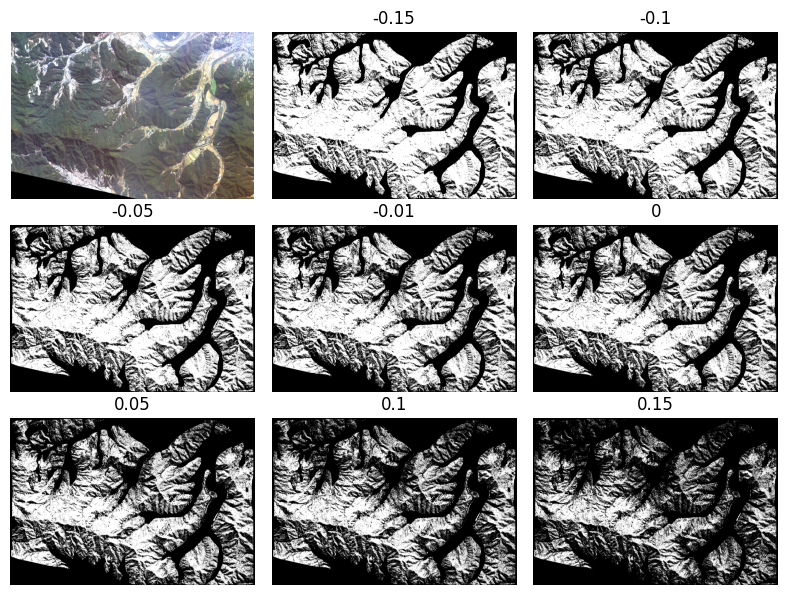

In [171]:
plt.figure(figsize=(8,6))
pre_arr = pre.read()[0]
plt.subplot(3,3,1)

pre_flip = cv2.flip(pre_vis.transpose(1,2,0), 0)

plt.imshow(pre_flip)
plt.axis("off")

for i, thres in enumerate([-0.15, -0.1, -0.05, -0.01, 0, 0.05, 0.10, 0.15]):
    plt.subplot(3,3,i+2)
    ndvi = np.where(pre_arr >= thres, 255, 0)
    plt.imshow(ndvi, cmap='gray')
    plt.title(thres)
    plt.axis("off")

plt.tight_layout()
plt.savefig('./pre_ndvi_threshold.png')

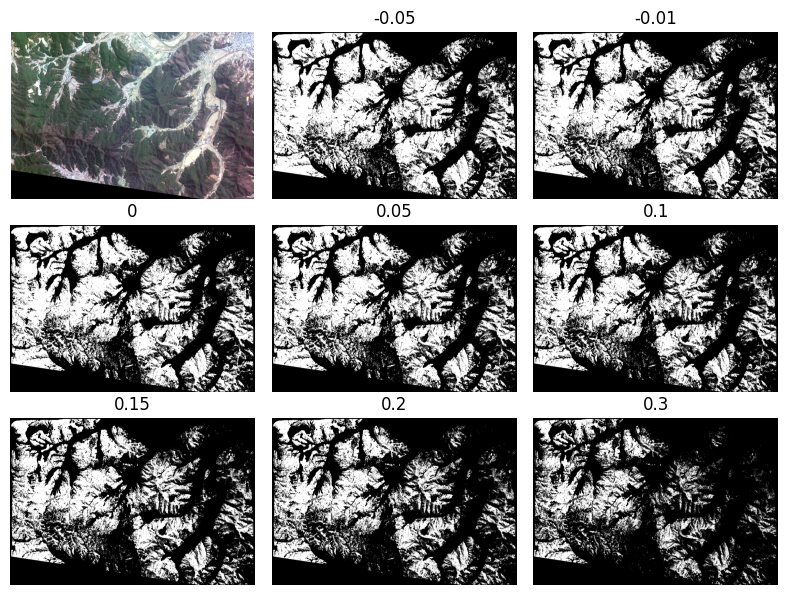

In [137]:
plt.figure(figsize=(8,6))
post_arr = post.read()[0]
plt.subplot(3,3,1)
plt.imshow(post_vis[:3].transpose(1,2,0).astype(np.uint8))
plt.axis("off")

for i, thres in enumerate([-0.15, -0.1, -0.05, -0.01, 0, 0.05, 0.10, 0.15]):
    plt.subplot(3,3,i+2)
    ndvi = np.where(post_arr >= thres, 255, 0)
    plt.imshow(ndvi, cmap='gray')
    plt.title(thres)
    plt.axis("off")

plt.tight_layout()
plt.savefig('./post_ndvi_threshold.png')